# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Quelques essais de `Transformers` **SANS fine-tuning**](#TRANS)
    * [2.1 `distilbert-base-uncased-finetuned-sst-2-english` SANS fine-tunin](#TRANS_REF1)
    * [2.2 `cardiffnlp/twitter-roberta-base-sentiment` SANS fine-tuning](#TRANS_REF2)

---
---
# 1. Préparatifs pour de la classification avec des Transformers <a class="anchor" id="init"></a> [⇪](#menu)

In [1]:
!pip install transformers datasets
!pip install dagshub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
#os.chdir("/content/drive/MyDrive/Openclassrooms/OC_AI_O7")
os.getcwd()

'/content/drive/MyDrive/Openclassrooms/OC_AI_07'

In [3]:
import time
import pathlib 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from dagshub import dagshub_logger, DAGsHubLogger
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline
from datasets import Dataset, load_dataset

import tensorflow as tf

random_seed = 0

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-870c2a75-6465-a88a-7c6d-85289da2705b)


### Chargeons quelques fonctions *maison* pour entrainer et évaluer les modèles, et initialisons un fichier pour enregistrer les scores
Ces fonctions ont été déportées dans le fichier classification_utils.py pour allèger le notebook

In [6]:
# Load classification helpers' functions & initialize a file to log the models' scores
from classification_utils import fit_model, get_scores, init_scores, find_best_threshold
init_scores("data/scores_NN_SelectTransformers.csv")

### Définissons les `fonctions et paramètres commun` à l'entrainement des différents modèles que l'on veut tester

In [7]:
# DagsHub 

def save_hyperparameters_to_dagshub(dlogger, model_name, archi_desc, layers, batch_size, sample_size):    
    dlogger.log_hyperparams(model_name=model_name)
    dlogger.log_hyperparams(archi_desc=archi_desc)
    dlogger.log_hyperparams(layers=layers)
    dlogger.log_hyperparams(batch_size=batch_size)
    dlogger.log_hyperparams(sample_size=sample_size)
    
def save_metrics_to_dagshub(dlogger, scores, best_threshold, history=None, step_num=1000, close=True):
    dlogger.log_metrics(scores, step_num=step_num)
    dlogger.log_metrics(best_threshold=best_threshold, step_num=step_num)
    if history:
        add_scores_to_dagshub(dlogger, history)

def get_layers_for_dagshub(model):
    
    layers_infos = []
    
    def search(layer):
        layer = dict(layer)
        
        nonlocal layers_infos
        
        if 'config' in layer:
    
            #if 'name' in layer['config']:
            #    print(" name:", layer['config']['name'])
            conf = {}
            if 'units' in layer['config']:
                conf["units"] = layer['config']['units']
            if 'output_dim' in layer['config']:
                conf['output_dim'] = layer['config']['output_dim']
            if 'rate' in layer['config']:
                conf['rate'] = layer['config']['rate']
            
            layers_infos.append((layer['class_name'], conf))
            
            if 'layer' in layer['config']:
                search(layer['config']['layer'])
        
    for layer in model.get_config()['layers']:
        search(layer)
        
    return layers_infos


def add_scores_to_dagshub(dlogger, history):
    for epoch, loss, accuracy, val_loss, val_accuracy in zip(
        history.epoch, 
        history.history['loss'], 
        history.history['accuracy'], 
        history.history['val_loss'], 
        history.history['val_accuracy']):
        scores = {
            'loss':loss, 
            'accuracy':accuracy, 
            'val_loss':val_loss, 
            'val_accuracy':val_accuracy
        }
        dlogger.log_metrics(scores, step_num=epoch) 

### Chargeons le jeu de données et préparons un `échantillon de travail` représentatif

In [8]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'text'],
    encoding='ISO-8859-1',
    #nrows=100000,
)
data_work.rename(columns={'text':'text', 'target':'label'}, inplace=True)
display(data_work.head(2), data_work.shape)

# Select samples
sample_size = 100000
data_work = data_work.groupby('label', group_keys=False).apply(lambda x: x.sample(sample_size//2, random_state=random_seed))
data_work.set_index('label', inplace=True, drop=True)
display(data_work.head(2), data_work.shape)

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...


(1452791, 2)

,text
label,
0,I dont have a background for my twitter stream...
0,I did many things but missed tweeting


(100000, 1)

In [9]:
dataset = Dataset.from_pandas(data_work)

In [10]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 100000
})

### Divisons le jeu de données en `Train`, `Valid` et `Test` sets

In [11]:
dsplit = dataset.train_test_split(test_size=0.2, seed=random_seed)
train_full_df = dsplit['train']
test_df = dsplit['test']

#dsplit = train_full_df.train_test_split(test_size=test_df.shape[0], seed=random_seed)
#train_df = dsplit['train']
#valid_df = dsplit['test']

print(f"train_full: {train_full_df.shape}, test: {test_df.shape}")

train_full: (80000, 2), test: (20000, 2)


---
---
# 2 - AutoModel & AutoTokenizer <a class="anchor" id="TRANS"></a> [⇪](#menu)

---
## 2.1 `distilbert-base-uncased-finetuned-sst-2-english` <a class="anchor" id="TRANS_REF1"></a> [⇪](#menu)

In [12]:
hug_model_name = "nlptown/bert-base-multilingual-uncased-sentiment" # 5 labels
hug_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest" # 3 labels mais fait pour
hug_model_name = "distilbert-base-uncased-finetuned-sst-2-english" # 2 labels
# finiteautomata/bertweet-base-sentiment-analysis ??
# "distilbert-base-uncased" --> fine-tuning

In [13]:
tf_model = TFAutoModelForSequenceClassification.from_pretrained(hug_model_name)
tokenizer = AutoTokenizer.from_pretrained(hug_model_name)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [14]:
def preprocess_function(x):
    return tokenizer(x['text'], truncation=True, padding="max_length", max_length=65, return_tensors="tf")

def batch_inference(data, model, tokenizer_func, sample_size=None, step_size=1000, verbose=1):

    out = {'logits':tf.zeros([0, data.shape[1]])}
    # predictions_batches = []

    max_index = data.shape[0] if sample_size is None else min(sample_size, data.shape[0])
    print("max_index", max_index)
    for i in range(0, max_index, step_size):
        max_step = min(max_index - i, step_size)

        tokens = tokenizer_func(data[i:i+max_step])
        preds = model(tokens)
        # predictions_batches.append(preds['logits'])

        out['logits'] = tf.concat(axis=0, values = [tf.cast(out['logits'], tf.float32), preds['logits']])
        
        if verbose:
            print(i, i+max_step)

    #out2 = tf.concat(predictions_batches, axis=1)
    return out #{'logits':out2}

#### Quelques tests simples

In [15]:
test_txt = ["I hate this stuff", "I really love it"]
test_tokens = tokenizer(test_txt, truncation=True, padding="max_length", max_length=65, return_tensors="tf")

In [16]:
tf_outputs = tf_model(test_tokens)
tf_outputs

TFSequenceClassifierOutput([('logits',
                             <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
                             array([[ 4.3156366, -3.500103 ],
                                    [-4.3277135,  4.691517 ]], dtype=float32)>)])

In [17]:
tf_predictions = tf.nn.softmax(tf_outputs.logits, axis=-1)
tf_predictions

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[9.9959689e-01, 4.0317379e-04],
       [1.2104466e-04, 9.9987888e-01]], dtype=float32)>

In [18]:
y_preds_proba = tf_predictions.numpy()
y_preds_proba = [x[1] for x in y_preds_proba]
y_preds_proba

[0.0004031738, 0.9998789]

#### Définissons un logger DagsHub pour enregistrer notre essai

In [19]:
model_name = "Transformers_REF1"
archi_desc = f"Auto* RAW \"{hug_model_name}\""
X_test_ready = test_df['text']
y_test = test_df['label']

In [20]:
dagslogger = DAGsHubLogger()

In [21]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, hug_model_name, None, dataset.shape[0])

### Inference

#### Utilisons une fonction pour faire des inférences en batch (sinon ça ne passe pas en mémoire)

In [22]:
t0 = time.perf_counter()
tf_outputs = batch_inference(test_df, tf_model, preprocess_function, sample_size=20000, step_size=1000, verbose=1)
#tf_outputs
inf_time = time.perf_counter() - t0
print(f"Inference time: {inf_time:.2f}s")

max_index 20000
0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
Inference time: 41.46s


#### Convertissons les scores en probabilité

In [23]:
tf_predictions = tf.nn.softmax(tf_outputs['logits'], axis=-1)

y_preds_proba = tf_predictions.numpy()
y_preds_proba = np.array([x[1] for x in y_preds_proba])
print(y_preds_proba)
print(len(y_preds_proba))

[1.1235430e-03 2.8306460e-03 9.9813831e-01 ... 3.3877930e-04 2.2621293e-02
 9.8465192e-01]
20000


#### Convertissons les probabilité en label (avec un threshold par défaut de 0.5)

In [24]:
y_preds = (y_preds_proba >= 0.5).astype("int")
y_preds

array([0, 0, 1, ..., 0, 0, 1])

### Evaluate

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Transformers_REF1 ------------------------------------------------------------------------------

             ROC_AUC : 0.7957
                  F1 : 0.6864
            ACCURACY : 0.7158
           PRECISION : 0.7696
              RECALL : 0.6194
   AVERAGE_PRECISION : 0.7958

       TRAINING-TIME : 0.0000
      INFERENCE-TIME : 41.4613

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.68      0.81      0.74      9961
Prediction = 1       0.77      0.62      0.69     10039

      accuracy                           0.72     20000
     macro avg       

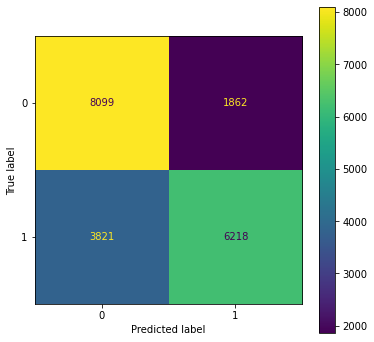

--- ROC AUC ---------------------------------------------------------------------------------------- 



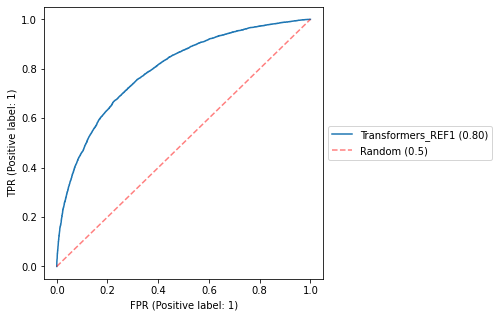

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



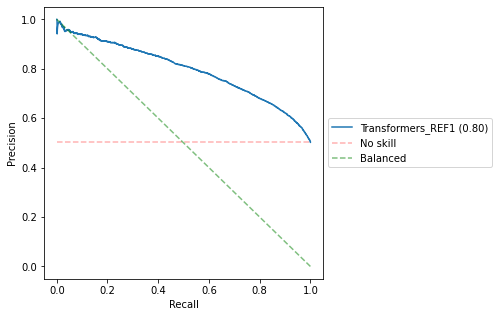

In [25]:
scores = get_scores(
    model_name,
    y_ref=y_test,
    y_pred=y_preds,
    y_pred_proba=y_preds_proba,
    threshold=0.5,
    training_time=0,
    inference_time=inf_time,
    show_roccurves=True,
    register=True,
)

#### Enregistrons les scores pour DagsHub

In [26]:
save_metrics_to_dagshub(dagslogger, scores, 0.5, None)
dagslogger.save() 
dagslogger.close()

---
## 2.2 `cardiffnlp/twitter-roberta-base-sentiment` <a class="anchor" id="TRANS_REF2"></a> [⇪](#menu)

In [ ]:
hug_model_name = "cardiffnlp/twitter-roberta-base-sentiment"

In [ ]:
tf_model = TFAutoModelForSequenceClassification.from_pretrained(hug_model_name)
tokenizer = AutoTokenizer.from_pretrained(hug_model_name)

In [ ]:
def preprocess_function(x):
    return tokenizer(x['text'], truncation=True, padding="max_length", max_length=65, return_tensors="tf")

def batch_inference(data, model, tokenizer_func, sample_size=None, step_size=1000, verbose=1):

    out = {'logits':tf.zeros([0, 3])}
    # predictions_batches = []

    max_index = data.shape[0] if sample_size is None else min(sample_size, data.shape[0])
    print("max_index", max_index)
    for i in range(0, max_index, step_size):
        max_step = min(max_index - i, step_size)

        tokens = tokenizer_func(data[i:i+max_step])
        preds = model(tokens)
        # predictions_batches.append(preds['logits'])

        out['logits'] = tf.concat(axis=0, values = [tf.cast(out['logits'], tf.float32), preds['logits']])
        
        if verbose:
            print(i, i+max_step)

    #out2 = tf.concat(predictions_batches, axis=1)
    return out #{'logits':out2}

#### Quelques tests simples

In [ ]:
test_txt = ["I hate this stuff", "I really love it"]
test_tokens = tokenizer(test_txt, truncation=True, padding="max_length", max_length=65, return_tensors="tf")

In [ ]:
tf_outputs = tf_model(test_tokens)
tf_outputs

In [ ]:
tf_predictions = tf.nn.softmax(tf_outputs.logits, axis=-1)
tf_predictions

In [ ]:
y_preds_proba = tf_predictions.numpy()
y_preds_proba = [x[1] for x in y_preds_proba]
y_preds_proba

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
model_name = "Transformers_REF2"
archi_desc = f"Auto* RAW \"{hug_model_name}\""
X_test_ready = test_df['text']
y_test = test_df['label']

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, hug_model_name, None, dataset.shape[0])

### Inference

In [ ]:
t0 = time.perf_counter()
tf_outputs = batch_inference(test_df, tf_model, preprocess_function, sample_size=20000, step_size=1000, verbose=1)
#tf_outputs
inf_time = time.perf_counter() - t0
print(f"Inference time: {inf_time:.2f}s")

#### Convertissons les scores en probabilité

In [ ]:
tf_outputs['logits']

In [ ]:
tf_predictions = tf.nn.softmax(tf_outputs['logits'], axis=-1)

y_preds_proba = tf_predictions.numpy()
y_preds_proba = np.array([x[2] for x in y_preds_proba])
print(y_preds_proba)
print(len(y_preds_proba))

#### Convertissons les probabilité en label (avec un threshold par défaut de 0.5)

In [ ]:
y_preds = (y_preds_proba >= 0.5).astype("int")
y_preds

### Evaluate

In [ ]:
scores = get_scores(
    model_name,
    y_ref=y_test,
    y_pred=y_preds,
    y_pred_proba=y_preds_proba,
    threshold=0.5,
    training_time=0,
    inference_time=inf_time,
    show_roccurves=True,
    register=True,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, 0.5, None)
dagslogger.save() 
dagslogger.close()